<a href="https://colab.research.google.com/github/ravichas/AMPL-workshop-2/blob/main/W03_EDA_merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Merge datasets, collapse duplicates, final curation steps

In this notebook we will merge datasets, collapse duplicates and carry out final curation for datasets from ChEMBL, DTC and ExCAPE-DB.

- Here is a list of database sources used in this notebook:
  - ChEMBL: https://www.ebi.ac.uk/chembl/
  - DTC: https://drugtargetcommons.fimm.fi/
  - ExCAPE-DB: https://solr.ideaconsult.net/search/excape/
- The target we're working on in this notebook is Histamine Receptor H1 (HRH1)

## AMPL installation (only for COLAB notebooks; ~ 4 minutes)

Comment the following code chunk if you are running on a pre-installed AMPL system

In [1]:
!echo "Beginning time"
!date

!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

!pip install deepchem-nightly

import deepchem
deepchem.__version__

! pip install umap
! pip install llvmlite==0.34.0  --ignore-installed
! pip install umap-learn
! pip install molvs
! pip install bravado

import deepchem as dc

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

!echo "Ending time"
!date

Beginning time
Mon Jul 12 19:43:47 UTC 2021
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3501  100  3501    0     0  85390      0 --:--:-- --:--:-- --:--:-- 85390


add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added conda-forge to channels
added omnia to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda

     |████████████████████████████████| 317kB 12.7MB/s 
  Created wheel for deepchem-nightly: filename=deepchem_nightly-2.3.0-cp37-none-any.whl size=383676 sha256=cd76893f9168fcfae8cbc058d1331bf08f9c260fa58123ec602feef359e2f2a9
  Stored in directory: /root/.cache/pip/wheels/4e/4c/b9/91b0715869556df7c02a6e580f82c539b5b92aedd1dc91cf84
Successfully built deepchem-nightly
  Created wheel for umap: filename=umap-0.1.1-cp37-none-any.whl size=3568 sha256=239b2f913c946ae58208a0ed28a0ce2d98a572a222fcaa6715aeb501bce49f65
  Stored in directory: /root/.cache/pip/wheels/7b/29/33/b4d917dc95f69c0a060e2ab012d95e15db9ed4cc0b94ccac26
Successfully built umap
     |████████████████████████████████| 24.6MB 128kB/s 
     |████████████████████████████████| 81kB 6.1MB/s 
     |████████████████████████████████| 1.1MB 20.1MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=1cd63431b7c919a722f8e720fa

## Load packages

In [2]:
%matplotlib inline
# manipulate data
import pandas as pd

# plot data
import numpy as np
import matplotlib.pyplot as plt

# curate data
from atomsci.ddm.utils import struct_utils
from atomsci.ddm.utils import curate_data
from atomsci.ddm.pipeline import dist_metrics

# Chemistry functions
from rdkit import Chem

# visualize data
import seaborn as sns
import matplotlib_venn as mpv
from scipy.stats import pearsonr

# set pandas options
pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

%config Completer.use_jedi = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.


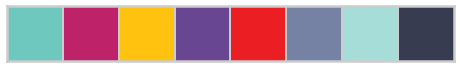

In [3]:
# set up visualization parameters
sns.set_context("poster")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10,10]

colors = [
    "#6EC8BE",
    "#BE2369",
    "#FFC30F",
    "#694691",
    "#EB1E23",
    "#7682A4",
    "#A7DDD8",
    "#373C50",
]
# Set your custom color palette
pal=sns.color_palette(colors)
sns.set_palette(pal)
sns.palplot(pal)

## Load Data

In [4]:
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/HRH1_ChEMBL_SMILES.csv
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/HRH1_DTC_SMILES.csv    
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/HRH1_Excape_SMILES.csv

chembl = pd.read_csv("HRH1_ChEMBL_SMILES.csv", index_col=0)
dtc = pd.read_csv("HRH1_DTC_SMILES.csv", index_col=0)
excape = pd.read_csv("HRH1_Excape_SMILES.csv", index_col=0)

--2021-07-12 19:46:50--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/HRH1_ChEMBL_SMILES.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1966971 (1.9M) [text/plain]
Saving to: ‘HRH1_ChEMBL_SMILES.csv’

HRH1_ChEMBL_SMILES. 100%[===================>]   1.88M  --.-KB/s    in 0.08s   

2021-07-12 19:46:50 (23.1 MB/s) - ‘HRH1_ChEMBL_SMILES.csv’ saved [1966971/1966971]

--2021-07-12 19:46:50--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/HRH1_DTC_SMILES.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaitin

In [5]:
excape.head(3)

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
0,BAAHTFHSCKWFDS-UHFFFAOYNA-N,CHEMBL3238444,3269,N,4.53,chembl20,1338137,9606,HRH1,2055,N1(CCCCC1)CCCOC=2C=CC(=CC2)N3C(=NN=C3C)C,Cc1nnc(C)n1-c1ccc(OCCCN2CCCCC2)cc1
1,BACLISNXCXJOMR-ZYMSVLFVNA-N,CHEMBL559664,3269,A,7.40,chembl20,745951,9606,HRH1,2055,N1(C)C(=O)N(C(=CC1=O)N2CCN(CC2)CCCN3C4=C(SC5=C...,Cn1c(N2CCN(CCCN3c4ccccc4Sc4ccc(CC(=O)O)cc43)CC...
2,BDMUROBIUYESLK-UHFFFAOYNA-N,CHEMBL157273,3269,A,6.40,chembl20,84547,9606,HRH1,2055,N=1C=CC(=CC1)CCCCCCCCCCCCN,NCCCCCCCCCCCCc1ccncc1


# Data curation, merging and final dataset EDA
### ChEMBL

In [6]:
print('ChEMBL shape:', chembl.shape)
print('ChEMBL NA standard values:', chembl[chembl.Standard_Value.isna()].shape)
print('ChEMBL NA pValues:', chembl[chembl.pChEMBL_Value.isna()].shape)

ChEMBL shape: (3844, 47)
ChEMBL NA standard values: (1695, 47)
ChEMBL NA pValues: (2099, 47)


In [7]:
# rescue NA pChemblValues
chembl['pChEMBL_Value_nM'] = -np.log10(chembl.Standard_Value_nM/1000000000)
chembl[chembl.pChEMBL_Value_nM.isna()].shape

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(1695, 48)

In [8]:
chembl.Standard_Type.value_counts()

Ki      2518
IC50    1249
EC50      77
Name: Standard_Type, dtype: int64

In [9]:
# select pIC50 values
vals = ['EC50', 'IC50']
print(chembl.shape)
chembl=chembl[chembl.Standard_Type.isin(vals)]
print(chembl.shape)

(3844, 48)
(1326, 48)


In [10]:
print(chembl[chembl.pChEMBL_Value_nM.isna()].shape)
print(chembl[chembl.base_rdkit_smiles.isna()].shape)

(828, 48)
(0, 48)


In [11]:
# drop NA pIC50's & smiles
chembl=chembl.dropna(axis=0, subset = ['pChEMBL_Value_nM','base_rdkit_smiles'])
print(chembl.shape)

(498, 48)


In [12]:
# note weird punctuation
chembl.Standard_Relation.unique()

array(["'='", "'>'", "'<'", "'~'"], dtype=object)

In [13]:
# flip arrows and fix punctuation for relation column to reflect pValues not normal values
chembl['pRelation'] = chembl.Standard_Relation
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'<'", ">", chembl.pRelation)
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'>'", "<", chembl.pRelation)
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'='", "=", chembl.pRelation)
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'~'", "=", chembl.pRelation)


chembl['pStandard_Type']='p'+chembl.Standard_Type

chembl[['Standard_Relation', 'pRelation']].head()

,Standard_Relation,pRelation
28,'=',=
30,'=',=
31,'>',<
32,'=',=
33,'=',=


In [14]:
display(chembl[['Standard_Type', 'Standard_Relation', 'Standard_Value_nM']].head())
chembl[['pStandard_Type', 'pRelation', 'pChEMBL_Value_nM']].head()

,Standard_Type,Standard_Relation,Standard_Value_nM
28,IC50,'=',6.36
30,IC50,'=',6.55
31,EC50,'>',10000.00
32,IC50,'=',6.39
33,IC50,'=',5.04


,pStandard_Type,pRelation,pChEMBL_Value_nM
28,pIC50,=,8.196543
30,pIC50,=,8.183759
31,pEC50,<,5.000000
32,pIC50,=,8.194499
33,pIC50,=,8.297569


In [15]:
# check for empty values in other important columns
chembl[chembl.Molecule_ChEMBL_ID.isna()]

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles,pChEMBL_Value_nM,pRelation,pStandard_Type


### Curate individual data frames
- remove bad duplicates (the ones with too much variability between measurements)
- average duplicate measurements, accounting for censored values (> , <)

In [16]:
chembl_rm = curate_data.average_and_remove_duplicates(column='pChEMBL_Value_nM', 
                                                      max_stdev=2, 
                                                      tolerance=100,
                                                      list_bad_duplicates='Yes', 
                                                      rm_duplicate_only=True, 
                                                      data=chembl, 
                                                      compound_id='Molecule_ChEMBL_ID', 
                                                      smiles_col='base_rdkit_smiles')

Bad duplicates removed from dataset
Dataframe size (482, 54)
List of 'bad' duplicates removed
    Molecule_ChEMBL_ID  pChEMBL_Value_nM  VALUE_NUM_mean   Perc_Var  \
45          CHEMBL1172          8.735182        6.581986  32.713481   
66          CHEMBL1172          4.795880        6.581986  27.136273   
286         CHEMBL1172          4.795880        6.581986  27.136273   
346         CHEMBL1172          8.001000        6.581986  21.559064   
116       CHEMBL330366          5.000000        6.761439  26.051248   
154       CHEMBL330366          8.522879        6.761439  26.051248   
128       CHEMBL411691          8.349692        6.907833  20.872816   
16        CHEMBL537027          5.465974        6.907833  20.872816   
261          CHEMBL564          8.464073        7.037037  20.278944   
374          CHEMBL564          5.610000        7.037037  20.278944   
222          CHEMBL908          9.000000        7.530001  19.521898   
265          CHEMBL908          6.060002        7.5300

In [17]:
thresh=-np.log10(100/1000000000) # IC50 of 100nM for threshold --> pIC50
thresh

7.0

In [18]:
print(chembl_rm.shape)
chembl_cur = curate_data.aggregate_assay_data(chembl_rm, value_col = 'pChEMBL_Value_nM', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Molecule_ChEMBL_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
print(chembl_cur.shape)
chembl_cur.head()

(482, 54)
0 entries in input table are missing SMILES strings
379 unique SMILES strings are reduced to 379 unique base SMILES strings
(379, 5)


,compound_id,base_rdkit_smiles,relation,pXC50,active
0,CHEMBL115280,O=C1NCN(c2ccccc2)C12CCN(Cc1cccc(Oc3ccccc3)c1)CC2,,6.304518,0
1,CHEMBL4527708,CC[C@]12CCCN(C(=O)c3cccc(Br)c3)CCc3c(n(c4ccccc...,,5.380907,0
2,CHEMBL331077,CN(C)CC1CC2c3ccccc3Cc3ccncc3N2O1,>,6.000000,0
3,CHEMBL431458,COc1cc(C(=O)N2CCC(CCN3CCC(C(=O)c4nc5ccccc5n4Cc...,,7.405565,1
4,CHEMBL82635,Cc1cccc2c1Cc1ccccc1C1CC(CN(C)C)ON21,,8.219971,1


In [19]:
chembl_cur.to_csv("HRH1_ChEMBL_cur.csv")

### DTC Curation

In [20]:
dtc['compound_id'] = np.where(dtc.compound_id.isna(),    
                              dtc.standard_inchi_key, 
                              dtc.compound_id)
dtc[dtc.compound_id.isna()]

,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments,pDTC_Value,SMILES,base_rdkit_smiles


In [21]:
dtc['compound_id'].isna().sum()

0

In [22]:
# DTC
# select pIC50 values
vals = ['EC50', 'IC50', 'PIC50']
print(dtc.shape)
dtc=dtc[dtc.standard_type.isin(vals)]
print(dtc.shape)

# flip arrows for relation column to reflect pValues not normal values
dtc['pRelation'] = dtc.standard_relation
dtc['pRelation'] = np.where(dtc.standard_relation == "<", ">", dtc.pRelation)
dtc['pRelation'] = np.where(dtc.standard_relation == ">", "<", dtc.pRelation)
dtc['pRelation'] = np.where(dtc.standard_relation == "=", "=", dtc.pRelation)
dtc['pRelation'] = np.where(dtc.standard_relation == "~", "=", dtc.pRelation)

print(dtc.pRelation.unique())

dtc=dtc.dropna(axis=0, subset = ['pDTC_Value','base_rdkit_smiles'])
print(dtc.shape)

(3822, 36)
(1248, 36)
[nan '=' '<' '>']
(447, 37)


In [23]:
# remove bad duplicates
dtc_rm = curate_data.average_and_remove_duplicates(column='pDTC_Value', 
                                                   max_stdev=2, 
                                                   tolerance=100,
                                                   list_bad_duplicates='Yes', 
                                                   rm_duplicate_only=True, 
                                                   data=dtc, 
                                                   compound_id='compound_id', 
                                                   smiles_col='base_rdkit_smiles')

Bad duplicates removed from dataset
Dataframe size (434, 41)
List of 'bad' duplicates removed
      compound_id  pDTC_Value  VALUE_NUM_mean   Perc_Var  VALUE_NUM_std
135    CHEMBL1172    4.795880        6.398375  25.045340       2.266270
136    CHEMBL1172    8.000869        6.398375  25.045340       2.266270
368  CHEMBL330366    8.522879        6.761439  26.051248       2.491051
369  CHEMBL330366    5.000000        6.761439  26.051248       2.491051
428  CHEMBL411691    8.349692        6.907833  20.872816       2.039097
315  CHEMBL537027    5.465974        6.907833  20.872816       2.039097
420     CHEMBL564    5.610000        7.036721  20.275366       2.017688
421     CHEMBL564    8.463442        7.036721  20.275366       2.017688
356     CHEMBL908    9.000000        7.530001  19.521898       2.078893
357     CHEMBL908    6.060002        7.530001  19.521898       2.078893
138     CHEMBL998    2.823909        5.377021  47.481906       2.214099
139     CHEMBL998    6.537602        5.377

In [24]:
# aggregate duplicates
dtc_cur = curate_data.aggregate_assay_data(dtc_rm, value_col = 'pDTC_Value', 
                                              output_value_col = 'pXC50',
                                              id_col = 'compound_id', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
dtc_cur.to_csv("HRH1_DTC_cur.csv")
print(dtc_cur.shape)
print(dtc_cur.relation.unique())
dtc_cur.head()

0 entries in input table are missing SMILES strings
342 unique SMILES strings are reduced to 342 unique base SMILES strings
(342, 5)
['' '>' '<']


,compound_id,base_rdkit_smiles,relation,pXC50,active
0,CHEMBL115280,O=C1NCN(c2ccccc2)C12CCN(Cc1cccc(Oc3ccccc3)c1)CC2,,6.304518,0
1,CHEMBL331077,CN(C)CC1CC2c3ccccc3Cc3ccncc3N2O1,>,6.000000,0
2,CHEMBL431458,COc1cc(C(=O)N2CCC(CCN3CCC(C(=O)c4nc5ccccc5n4Cc...,,7.405565,1
3,CHEMBL82635,Cc1cccc2c1Cc1ccccc1C1CC(CN(C)C)ON21,,8.219683,1
4,CHEMBL1774497,Cn1c(N2CCCN(CCCN3c4ccccc4CCc4ccc(C(=O)O)cc43)C...,,7.154902,1


### Excape Curation

In [25]:
excape.columns

Index(['Ambit_InchiKey', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'SMILES', 'base_rdkit_smiles'],
      dtype='object')

In [26]:
excape[excape.Original_Entry_ID.isna()]

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles


In [27]:
# excape: has no relation col, so create one with all ''
excape['pRelation']=''
print(excape.shape)
print(excape.pRelation.unique())
excape=excape.dropna(axis=0, subset = ['pXC50','base_rdkit_smiles'])
print(excape.shape)

# remove bad duplicates
excape_rm = curate_data.average_and_remove_duplicates(column='pXC50', 
                                                      max_stdev=2, 
                                                      tolerance=100,
                                                      list_bad_duplicates='Yes', 
                                                      rm_duplicate_only=True, 
                                                      data=excape, 
                                                      compound_id='Original_Entry_ID', 
                                                      smiles_col='base_rdkit_smiles')

# aggregate duplicates
excape_cur = curate_data.aggregate_assay_data(excape_rm, 
                                              value_col = 'pXC50', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Original_Entry_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
excape_cur.to_csv("HRH1_Excape_cur.csv")
print(excape_cur.shape)
print(excape_cur.relation.unique())
excape_cur.head()

(1283, 13)
['']
(1268, 13)
Bad duplicates removed from dataset
Dataframe size (1266, 17)
List of 'bad' duplicates removed
     Original_Entry_ID  pXC50  VALUE_NUM_mean   Perc_Var  VALUE_NUM_std
1252         CHEMBL564    5.9            7.65  22.875817       2.474874
1253         CHEMBL564    9.4            7.65  22.875817       2.474874
0 entries in input table are missing SMILES strings
1232 unique SMILES strings are reduced to 1231 unique base SMILES strings
(1231, 5)
['']


,compound_id,base_rdkit_smiles,relation,pXC50,active
0,CHEMBL2158775,COc1ccccc1C[C@@H](C(=O)O)N1CCC(CN2CCC(Oc3ccc(C...,,7.20000,1
1,CHEMBL115280,O=C1NCN(c2ccccc2)C12CCN(Cc1cccc(Oc3ccccc3)c1)CC2,,6.30000,0
2,CHEMBL82635,Cc1cccc2c1Cc1ccccc1C1CC(CN(C)C)ON21,,8.22000,1
3,CHEMBL552057,Cn1c(N2CCN(CCCCN3c4ccccc4Sc4ccc(C(=O)O)cc43)CC...,,7.46000,1
4,60149,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,,9.29243,1


### Concatenate individual data sources, curate again

In [28]:
chembl = pd.read_csv("HRH1_ChEMBL_cur.csv", index_col=0)
dtc = pd.read_csv("HRH1_DTC_cur.csv", index_col=0)
excape = pd.read_csv("HRH1_Excape_cur.csv", index_col=0)

In [29]:
chembl_cur['datasource'] = 'chembl'
dtc_cur['datasource']='dtc'
excape_cur['datasource']='excape'

HRH1 = pd.concat([chembl_cur, dtc_cur, excape_cur])

print(HRH1.shape)

(1952, 6)


In [30]:
HRH1_rm = curate_data.average_and_remove_duplicates(column='pXC50', max_stdev=2, tolerance=100,
                                                      list_bad_duplicates='Yes', rm_duplicate_only=True, data=HRH1, 
                                                      compound_id='compound_id', smiles_col='base_rdkit_smiles')

Bad duplicates removed from dataset
Dataframe size (1952, 10)
List of 'bad' duplicates removed
Empty DataFrame
Columns: [compound_id, pXC50, VALUE_NUM_mean, Perc_Var, VALUE_NUM_std]
Index: []


In [31]:
HRH1_cur = curate_data.aggregate_assay_data(HRH1_rm, value_col = 'pXC50', 
                                              id_col = 'compound_id', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'relation',
                                              active_thresh=thresh)

print(HRH1_cur.shape)
print(HRH1.relation.unique())
HRH1_cur.head()

0 entries in input table are missing SMILES strings
1402 unique SMILES strings are reduced to 1402 unique base SMILES strings
(1402, 5)
['' '>' '<']


,compound_id,base_rdkit_smiles,relation,pXC50,active
0,CHEMBL2158775,COc1ccccc1C[C@@H](C(=O)O)N1CCC(CN2CCC(Oc3ccc(C...,,7.200000,1
1,CHEMBL115280,O=C1NCN(c2ccccc2)C12CCN(Cc1cccc(Oc3ccccc3)c1)CC2,,6.303012,0
2,CHEMBL82635,Cc1cccc2c1Cc1ccccc1C1CC(CN(C)C)ON21,,8.219885,1
3,CHEMBL552057,Cn1c(N2CCN(CCCCN3c4ccccc4Sc4ccc(C(=O)O)cc43)CC...,,7.457288,1
4,60149,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,,9.292430,1


In [32]:
HRH1_cur.relation.unique()

array(['', '<'], dtype=object)

In [33]:
HRH1_cur.to_csv("HRH1_merge.csv")

### Final curation steps
- filter out MW and pXC50 weird values

In [34]:
HRH1_cur = pd.read_csv("HRH1_merge.csv", index_col=0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


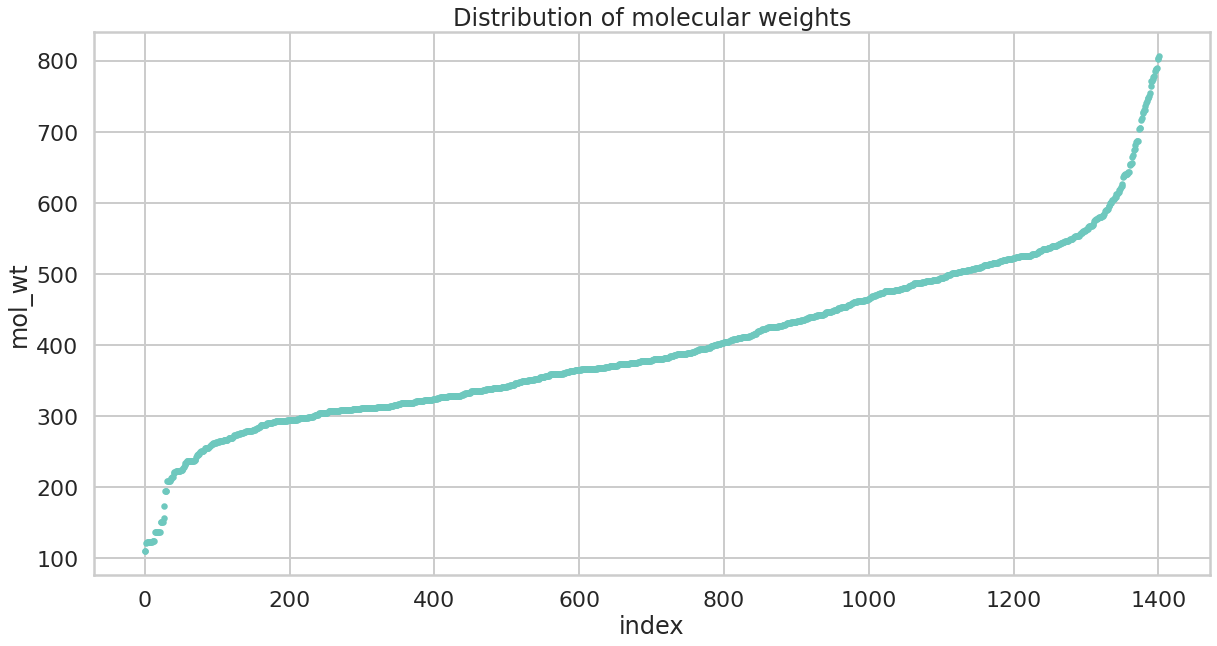

In [35]:
HRH1_cur["mol_wt"] = [Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smile)) for smile in HRH1_cur["base_rdkit_smiles"]]
HRH1_cur = HRH1_cur.sort_values('mol_wt')
HRH1_cur = HRH1_cur.reset_index(drop=True)
HRH1_cur = HRH1_cur.reset_index() # plot x axis as index #'s
fig,ax=plt.subplots(figsize=(20,10))
HRH1_cur.plot(kind='scatter', x='index', y='mol_wt', ax=ax);
plt.title("Distribution of molecular weights");

In [36]:
# filter for large MW's
print(HRH1_cur.shape)
HRH1_cur = HRH1_cur[HRH1_cur.mol_wt <1400]
print(HRH1_cur.shape)

(1402, 7)
(1402, 7)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


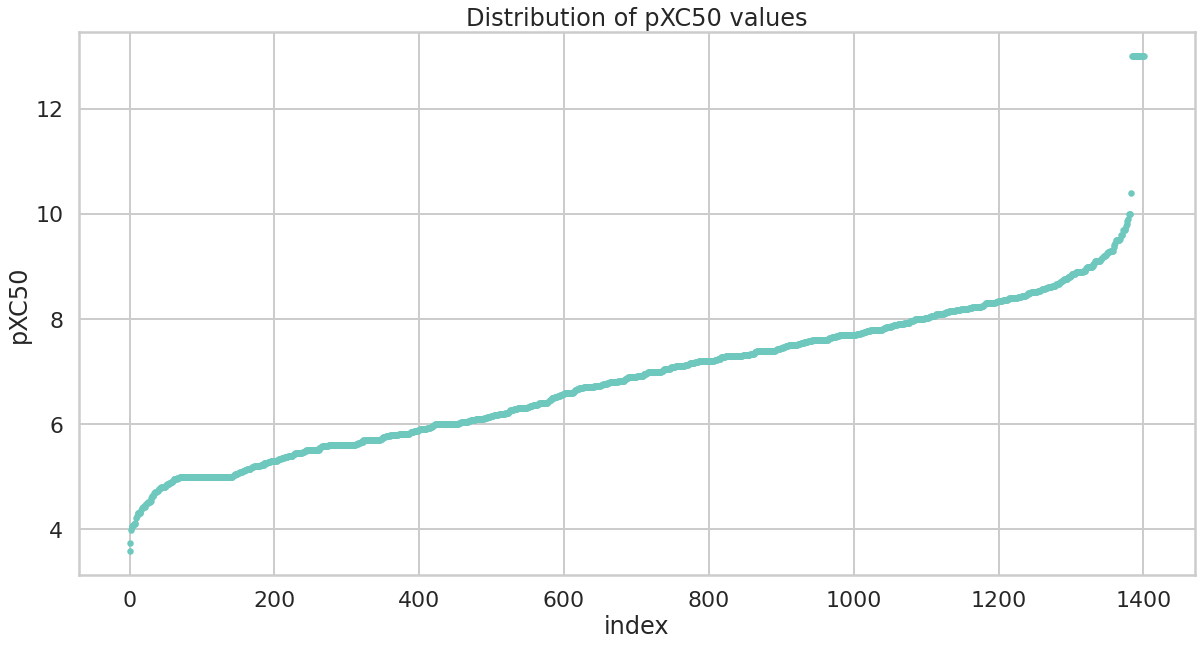

In [37]:
HRH1_cur = HRH1_cur.drop(columns=['index'])
HRH1_cur = HRH1_cur.sort_values('pXC50')
HRH1_cur = HRH1_cur.reset_index(drop=True)
HRH1_cur = HRH1_cur.reset_index() # plot x axis as index #'s
fig,ax=plt.subplots(figsize=(20,10))
HRH1_cur.plot(kind='scatter', x='index', y='pXC50', ax=ax);
plt.title("Distribution of pXC50 values");

In [38]:
# filter for weird pXC50 values
print(HRH1_cur.shape)
HRH1_cur = HRH1_cur[HRH1_cur.pXC50>2]
HRH1_cur = HRH1_cur[HRH1_cur.pXC50<14]
print(HRH1_cur.shape)

(1402, 7)
(1402, 7)


In [39]:
# check for na values
for col in HRH1_cur.columns:
  print(col, HRH1_cur[col].isna().values.any())

index False
compound_id False
base_rdkit_smiles False
relation True
pXC50 False
active False
mol_wt False


In [40]:
HRH1_cur.to_csv("HRH1_cur.csv")

In [41]:
# all these warnings are OK
from atomsci.ddm.pipeline import diversity_plots as dp
from rdkit import Chem
from scipy.stats.kde import gaussian_kde
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoDistMat
import logging

sns.set_context('poster')
ndist_max = 1000000

# a helper function
def plot_tani_dist_distr(dataset, smiles_col, dataset_name, **metric_kwargs):
    """
    Generate a density plot showing the distribution of distances between ecfp feature
    vectors, using the tanimoto metric.
    """
    log = logging.getLogger('ATOM')
    num_cmpds = len(dataset)
    if num_cmpds > 50000:
        log.warning("Dataset has %d compounds, too big to calculate distance matrix" % num_cmpds)
        return
    
    log.warning("Starting distance matrix calculation for %d compounds" % num_cmpds)
    feat_type = 'ecfp'
    dist_metric = 'tanimoto'
    smiles_arr1 = dataset[smiles_col].values
    mols1 = [Chem.MolFromSmiles(s) for s in smiles_arr1]
    fprints1 = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in mols1]
    dists = GetTanimotoDistMat(fprints1)
    
    log.warning("Finished calculation of %d distances" % len(dists))
    
    if len(dists) > ndist_max:
        # Sample a subset of the distances so KDE doesn't take so long
        dist_sample = np.random.choice(dists, size=ndist_max)
    else:
        dist_sample = dists

    dist_pdf = gaussian_kde(dist_sample)
    x_plt = np.linspace(min(dist_sample), max(dist_sample), 500)
    y_plt = dist_pdf(x_plt)
    fig, ax = plt.subplots(figsize=(8.0,8.0))
    ax.plot(x_plt, y_plt)
    ax.set_xlabel('%s distance' % dist_metric)
    ax.set_ylabel('Density')
    ax.set_title("%s dataset\nDistribution of %s distances between %s feature vectors" % (
                  dataset_name, dist_metric, feat_type))
    return dists

### Final EDA 
- how many actives & inactives are there?
- what's the dist. of pXC50 values?
- what are the final compound overlaps from the 3 curated datasets?
- what is the distribution of tanimoto distances in the compound sets?
- what is the final diversity plots? MCS? different ECFP radii?

In [42]:
HRH1_cur = pd.read_csv("HRH1_cur.csv", index_col=0)

In [43]:
HRH1_cur.active.sum()

649

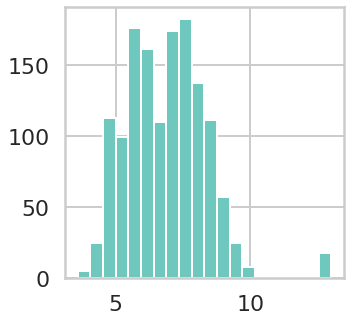

In [44]:
HRH1_cur.pXC50.hist(bins=20, figsize=(5,5));

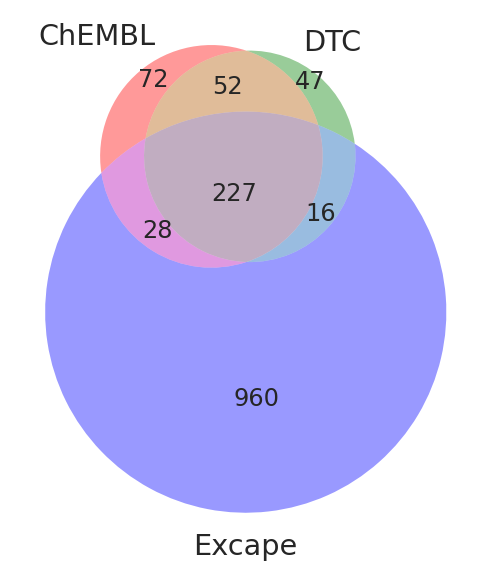

In [45]:
mpv.venn3([set(HRH1.loc[HRH1.datasource=='chembl','base_rdkit_smiles']),
           set(HRH1.loc[HRH1.datasource=='dtc','base_rdkit_smiles']),
           set(HRH1.loc[HRH1.datasource=='excape','base_rdkit_smiles']),],
          set_labels = ['ChEMBL','DTC','Excape']);

2021-07-12 19:47:30,476 Starting distance matrix calculation for 1402 compounds
2021-07-12 19:47:31,695 Finished calculation of 982101 distances


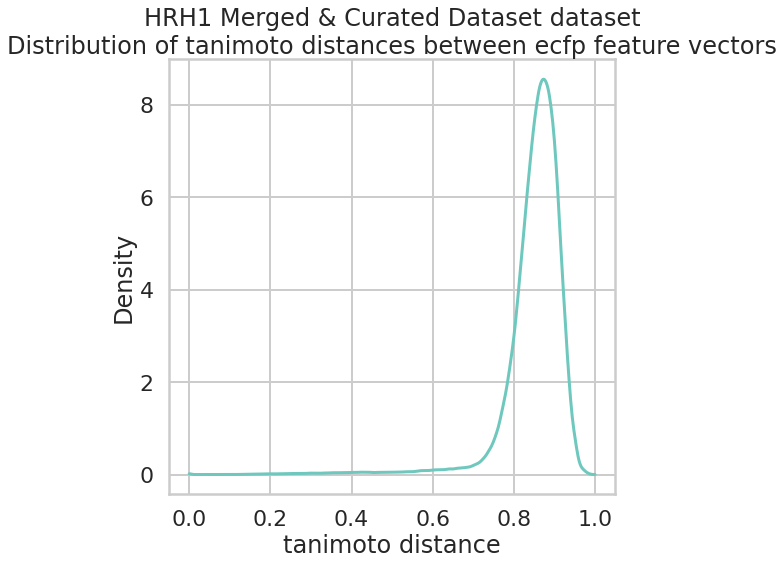

In [46]:
plot_tani_dist_distr(HRH1_cur, 'base_rdkit_smiles', 'HRH1 Merged & Curated Dataset');

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/atomsci/ddm/pipeline/diversity_plots.py:303: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tani_linkage = linkage(tani_dist, method='complete')


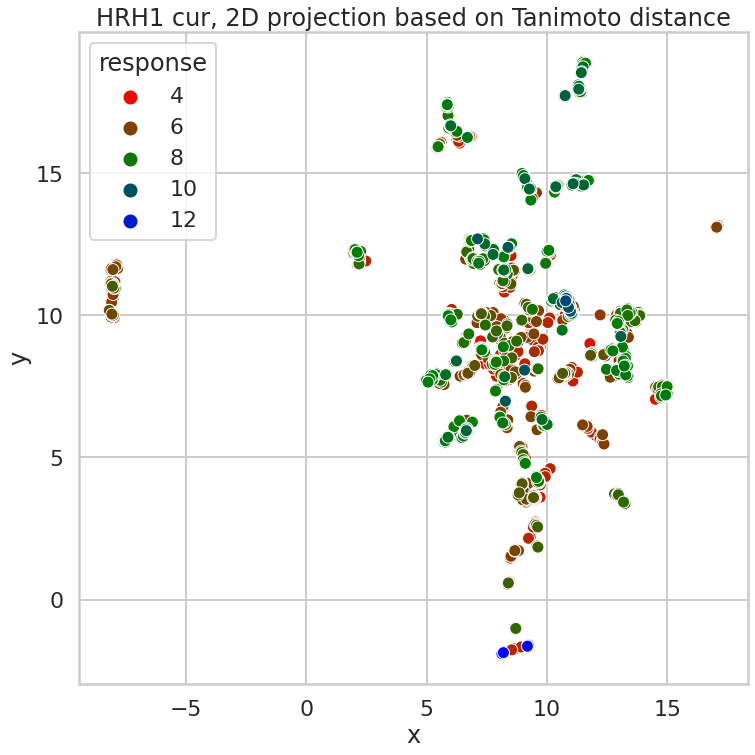

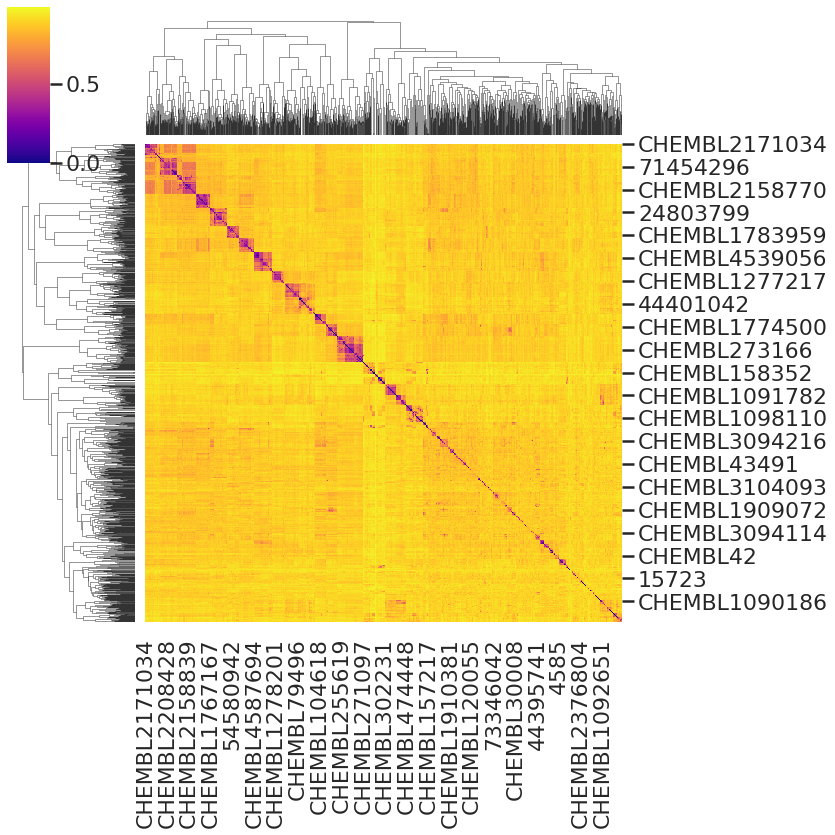

In [47]:
dp.diversity_plots('HRH1_cur.csv', datastore=False,
                   id_col ='compound_id', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pXC50')

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/usr/local/lib/python3.7/dist-packages/atomsci/ddm/pipeline/diversity_plots.py:303: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tani_linkage = linkage(tani_dist, method='complete')


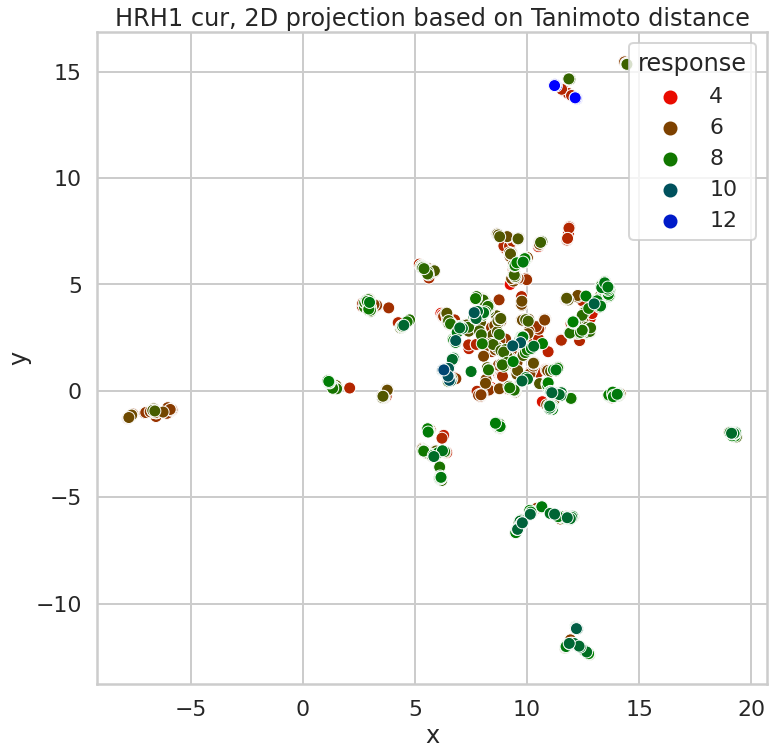

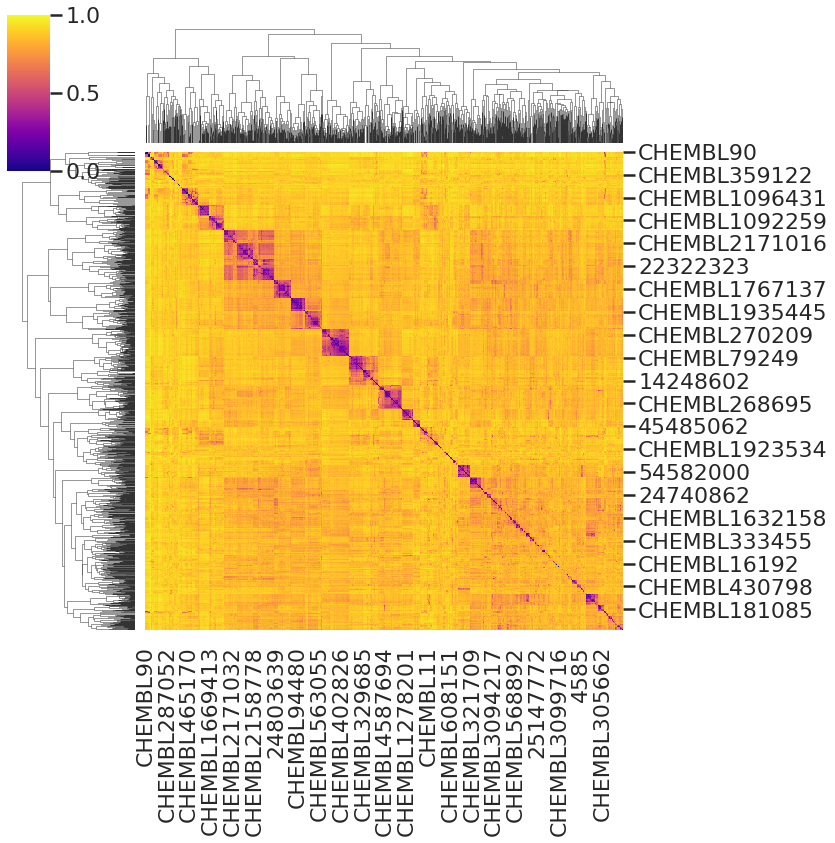

In [48]:
dp.diversity_plots('HRH1_cur.csv', datastore=False,
                   id_col ='compound_id', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pXC50',
                   ecfp_radius = 2)

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/usr/local/lib/python3.7/dist-packages/atomsci/ddm/pipeline/diversity_plots.py:303: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tani_linkage = linkage(tani_dist, method='complete')


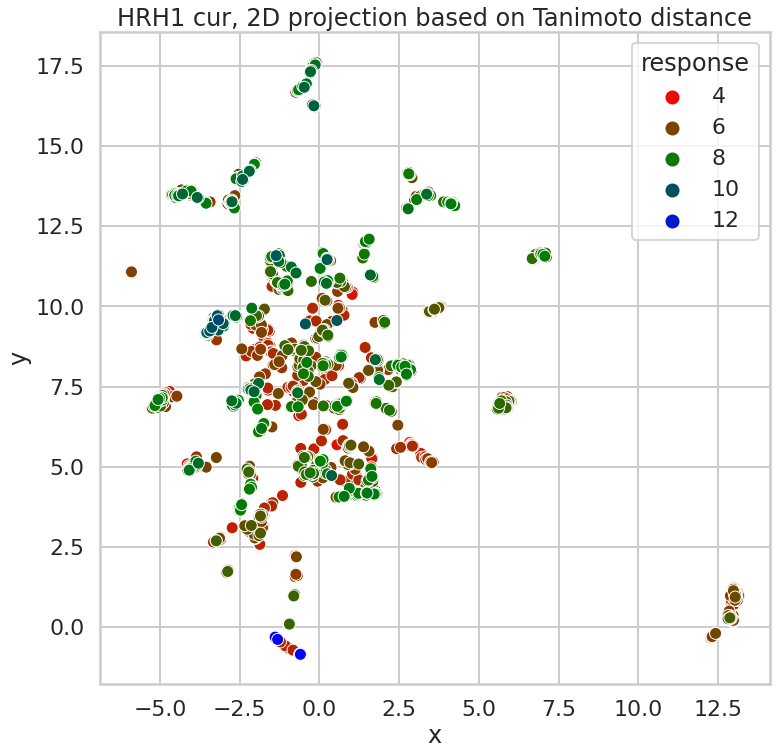

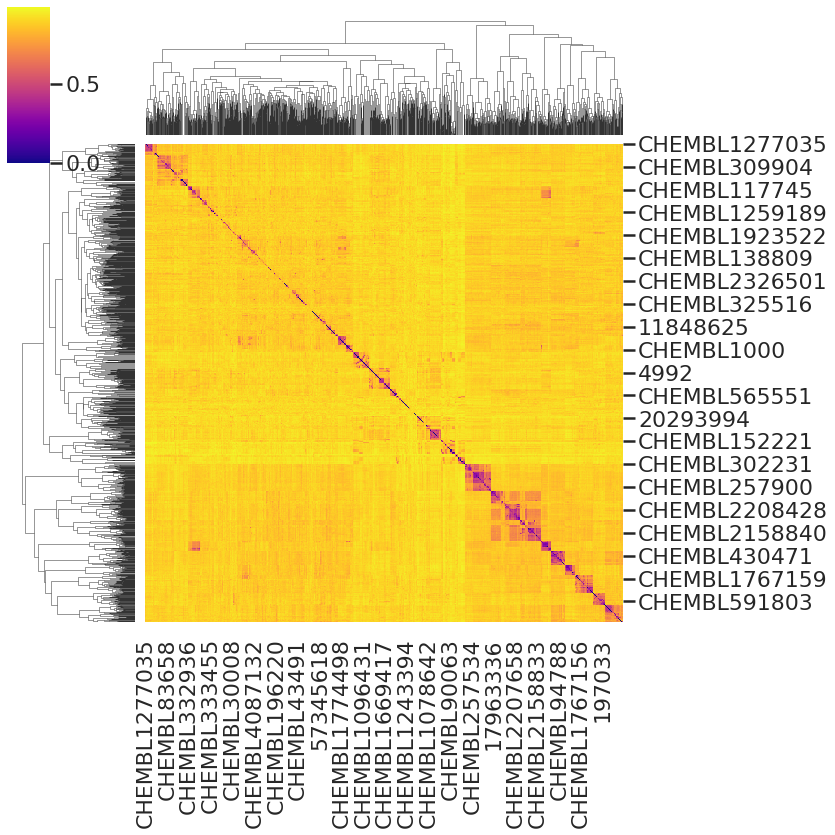

In [49]:
dp.diversity_plots('HRH1_cur.csv', datastore=False,
                   id_col ='compound_id', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pXC50',
                   ecfp_radius = 6)

In [50]:
# warning: takes a long time; use it on system with dedicated resources 
# dp.diversity_plots('HRH1_cur.csv', datastore=False,
#                    id_col ='compound_id', smiles_col = 'base_rdkit_smiles', 
#                    is_base_smiles=True, response_col = 'pXC50', 
#                    max_for_mcs=1500)

# Now you're ready to move on to the next stage of EDA & modeling: featurizing datasets
- featurize with structure-based fingerprints like ECFP
- or molecular descriptor sets like RDKit and Mordred
- these are high - dimensional datasets (200-2000 features or 'dimensions')
- so UMAP, tSNE and other dimensionality reduction techniques will help visualize the 'chemical space' of the dataset

In [52]:
!ls -ltr /content


total 96284
drwxr-xr-x 1 root root     4096 Jul  1 13:42 sample_data
-rw-r--r-- 1 root root     3501 Jul 12 19:43 conda_installer.py
drwxr-xr-x 2 root root     4096 Jul 12 19:43 __pycache__
-rw-r--r-- 1 root root 94235922 Jul 12 19:43 Miniconda3-latest-Linux-x86_64.sh
-rwxr--r-- 1 root root     1091 Jul 12 19:46 install_AMPL_GPU_test.sh
drwxr-xr-x 5 root root     4096 Jul 12 19:46 github
-rw-r--r-- 1 root root  1966971 Jul 12 19:46 HRH1_ChEMBL_SMILES.csv
-rw-r--r-- 1 root root  1703236 Jul 12 19:46 HRH1_DTC_SMILES.csv
-rw-r--r-- 1 root root   251639 Jul 12 19:46 HRH1_Excape_SMILES.csv
-rw-r--r-- 1 root root    32324 Jul 12 19:46 HRH1_ChEMBL_cur.csv
-rw-r--r-- 1 root root    28797 Jul 12 19:46 HRH1_DTC_cur.csv
-rw-r--r-- 1 root root    92734 Jul 12 19:47 HRH1_Excape_cur.csv
-rw-r--r-- 1 root root   109242 Jul 12 19:47 HRH1_merge.csv
-rw-r--r-- 1 root root   137689 Jul 12 19:47 HRH1_cur.csv
